In [52]:
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import math

fp = "G:\\My Drive\\Darby Work\\XRF fundamentals vs. MVA\\"

##### Import and format RMSE-CV and RMSE-P results

In [18]:
# import RMSE-CV results
rmsecv_results = pd.read_excel(fp+"Olympus_MVA_RMSEs_100621.xlsx", sheet_name="lasso all", header=1)
rmsecv_results.rename(columns={'RMSE-CV':'all_RMSE-CV'}, inplace=True)
# fix excel formatting
odd_rows = [num for num in rmsecv_results.index if num % 2 == 1]

for row in odd_rows:
    rmsecv_results.loc[row, 'Element'] = rmsecv_results.loc[row-1]['Element']
    rmsecv_results.loc[row, 'Limit'] = rmsecv_results.loc[row-1]['Limit']

# import RMSE-P results
rmsep_results = pd.read_csv(fp+"full_results_table.csv")
rmsep_results = rmsep_results[rmsep_results['num_range'] == '0-750']
rmsep_results.rename(columns={'RMSEP':'0-750_RMSEP'}, inplace=True)

##### Describe standards

In [3]:
predicted_elements = rmsep_results.element.unique()

metadata_path = "Z:\\data_pXRF\\MHC_Olympus_metadata.csv"
metadata = pd.read_csv(metadata_path)
# only Olympus-predicted samples, just pick one beam b/c duplicates
metadata = metadata[
    (metadata['Olympus-Predicted']=='yes') &
    (metadata['Filter']=='O1')
].reset_index(drop=True)
# only compositions
metadata = metadata.iloc[:,np.arange(start = 8,  stop= len(metadata.columns))]
# format columns
metadata.columns = metadata.columns.map(lambda x: x.split()[0])

limits_path = "Z:\\Millennium Set\\near_zero&outliers_summary_091021.xlsx"
limits = pd.read_excel(limits_path)
element_limits = limits[limits['Element'].isin(predicted_elements)
                    ][['Element', 'Outlier limit']].reset_index(drop=True)

In [4]:
elem_list = []
limit_list = []
n_list = []
avg_list = []
max_list = []

for element in predicted_elements:
    
    # filter just for element's comps
    data = metadata[element]
    
    # find limit for that element
    limit = float(element_limits[
        element_limits['Element'] == element
    ].reset_index()['Outlier limit'][0])
    
    # remove NaN and those above
    data = data[
       ~(data.isnull()) &
        (data <= limit)
    ]
    
    # calculate and append lists
    elem_list.append(element)
    limit_list.append(int(limit))
    
    avg = round(data.mean(),2)
    avg_list.append(avg)
    
    maximum = round(data.max(),2)
    max_list.append(maximum)
    
    n = len(data)
    n_list.append(n)
    
comps_desc = pd.DataFrame({
    "element" : elem_list,
    "limit" : limit_list,
    "n" : n_list,
    "average" : avg_list,
    "max" : max_list
})

##### Get error as % of average concentration

In [19]:
rmsep_results['0-750_RMSEP_per'] = 'NaN'
for row in rmsep_results.index:
    # only calculate for elements with 2+ test standards
    if rmsep_results.loc[row, 'R2']!='Not enough test samples above LOQ':
        rmsep_results.loc[row, '0-750_RMSEP_per'] = round(
            (rmsep_results.loc[row]['0-750_RMSEP'] / rmsep_results.loc[row]['avg_comp'])*100,1)

In [20]:
rmsecv_results = pd.merge(rmsecv_results, 
                          comps_desc[['element','average']],
                          how='left',
                         left_on='Element',
                         right_on='element')

rmsecv_results['all_RMSE-CV_per'] = 'NaN'
for row in rmsecv_results.index:
    rmsecv_results.loc[row, 'all_RMSE-CV_per'] = round(
        (rmsecv_results.loc[row]['all_RMSE-CV'] / rmsecv_results.loc[row]['average'])*100,1)

##### Merge and plot

In [24]:
results = pd.merge(rmsecv_results, 
                   rmsep_results, 
                   how='inner', 
                   left_on=['Element', 'Beam'], 
                   right_on=['element', 'filter'])[
    ['Element', 'filter', 'all_RMSE-CV', 'all_RMSE-CV_per', '0-750_RMSEP', '0-750_RMSEP_per']
]

# convert to float
for column in ['all_RMSE-CV', 'all_RMSE-CV_per', '0-750_RMSEP', '0-750_RMSEP_per']:
    results[column] = results[column].astype(float)

{'Cl', 'U', 'Ta', 'As', 'Cu', 'Bi', 'Hg', 'Sn', 'W', 'S', 'Al2O3', 'Zn', 'Mo', 'Pb', 'Ni', 'Cr', 'V', 'Th', 'Sr'} could not be plotted b/c NaN RMSE-P


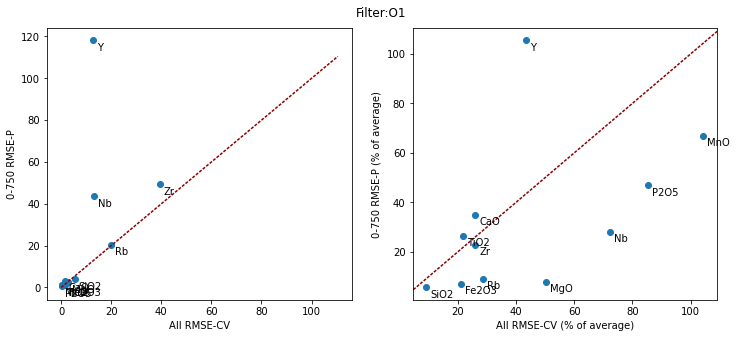

{'Bi', 'W', 'As'} could not be plotted b/c NaN RMSE-P


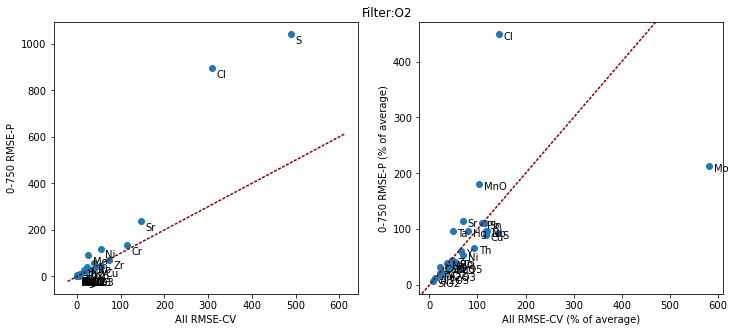

In [84]:
for beam in ['O1', 'O2']:
    
    df = results[results['filter']==beam]
    e1 = set(df.Element.unique())
    
    # remove rows with an NaN RMSE-P
    df.dropna(axis=0, inplace=True)
    df.reset_index(inplace = True, drop=True)
    e2 = set(df.Element.unique())
    print(e1-e2, "could not be plotted b/c NaN RMSE-P")
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (12,5))
    
    x = 'all_RMSE-CV'
    y = '0-750_RMSEP'
    
    ax1.scatter(df[x], df[y])
    ax2.scatter(df[x+'_per'], df[y+'_per'])
    
    # formats for both plots
    for ax in [ax1, ax2]:
        # 1:1 line
        y_bot, y_top = plt.ylim() # get current auto-axes
        x_bot, x_top = plt.xlim()
        top = max(y_top, x_top)
        bot = min(y_bot, x_bot, 0)
        plt.xlim(x_bot, x_top) # reset to original axes
        plt.ylim(y_bot, y_top)
        one_one = ax.plot([bot,top], [bot,top], c='darkred', linewidth=1.5, linestyle = (0, (2, 1)), label = "1:1")

    # add labels
    if beam == 'O1':
        off1x = 1.5
        off1y = 5
        off2x = 1.5
        off2y = 4
        ax2.text(-15, 115, "Filter:"+beam, fontsize = 12)
    else: 
        off1x = 10
        off1y = 40
        off2x = 10
        off2y = 10
        ax2.text(-140, 480, "Filter:"+beam, fontsize = 12)

    for i in df.index:
        ax1.text(df[x][i]+off1x, df[y][i]-off1y, df['Element'][i])
        ax2.text(df[x+'_per'][i]+off2x, df[y+'_per'][i]-off2y, df['Element'][i])

    ax1.set_xlabel('All RMSE-CV')
    ax1.set_ylabel('0-750 RMSE-P')
    
    ax2.set_xlabel('All RMSE-CV (% of average)')
    ax2.set_ylabel('0-750 RMSE-P (% of average)')
    
    plt.show()